In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import RobertaTokenizer, RobertaModel
# from matplotlib import style
import random
import pickle
# style.use("dark_background")
seed_val = 994
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device=torch.device("cuda")

In [2]:
# %history
train_df=pd.read_csv("./MELD/data/MELD/train_sent_emo.csv")
val_df=pd.read_csv("./MELD/data/MELD/dev_sent_emo.csv")
test_df=pd.read_csv("./MELD/data/MELD/test_sent_emo.csv")


train_df.head()

# file = open("IEMOCAP_features_bert.pkl",'rb')
# object_file = pickle.load(file)
# file.close()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


0    4710
4    1743
1    1205
6    1109
3     683
5     271
2     268
Name: Emotion, dtype: int64


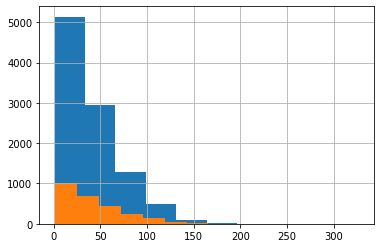

In [3]:

mapping ={'neutral':0, 'surprise':1, 'fear':2, 'sadness':3, 'joy':4, 'disgust':5, 'anger':6}

mapping2={"Chandler":0,"Phoebe":1,"Monica":2,"Ross":3,"Joey":4,"Rachel":5}

train_df=train_df.replace({"Emotion":mapping})# mapping labels to integer
val_df=val_df.replace({"Emotion":mapping})
test_df=test_df.replace({"Emotion":mapping})

train_df=train_df.replace({"Speaker":mapping2})# mapping labels to integer
val_df=val_df.replace({"Speaker":mapping2})
test_df=test_df.replace({"Speaker":mapping2})


train_text=train_df["Utterance"].tolist()
val_text=val_df["Utterance"].tolist()
test_text=test_df["Utterance"].tolist()


train_labels=train_df["Emotion"]
val_labels=val_df["Emotion"]
test_labels=test_df["Emotion"]

train_dia_id=train_df["Dialogue_ID"]
val_dia_id=val_df["Dialogue_ID"]
test_dia_id=test_df["Dialogue_ID"]

train_speaker=train_df["Speaker"]
val_speaker=val_df["Speaker"]
test_speaker=test_df["Speaker"]

# print(train_text,train_labels)

len_train=[len(j) for j in train_text]
len_test=[len(i) for i in test_text]

pd.Series(len_train).hist()
pd.Series(len_test).hist()

print(train_df.Emotion.value_counts())



In [4]:
print(train_text[6])
print(train_df["Speaker"].value_counts())



I see.
4                   1510
3                   1458
5                   1435
1                   1321
2                   1299
                    ... 
Phoebe/Waitress        1
Vince                  1
Gary Collins           1
Hold Voice             1
Front Desk Clerk       1
Name: Speaker, Length: 260, dtype: int64


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaModel.from_pretrained('roberta-large')

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
tokens_train=tokenizer(train_text,
                                         max_length=80,
                                         padding=True,
                                         truncation=True)

tokens_val=tokenizer(val_text,
                                         max_length=80,
                                         padding=True,
                                         truncation=True)

tokens_test=tokenizer(test_text,
                                         max_length=80,
                                         padding=True,
                                         truncation=True)

In [7]:
train_seq=torch.tensor(tokens_train["input_ids"])
train_mask=torch.tensor(tokens_train["attention_mask"])
train_label=torch.tensor(train_labels.tolist())

val_seq=torch.tensor(tokens_val["input_ids"])
val_mask=torch.tensor(tokens_val["attention_mask"])
val_label=torch.tensor(val_labels.tolist())

test_seq=torch.tensor(tokens_test["input_ids"])
test_mask=torch.tensor(tokens_test["attention_mask"])
test_label=torch.tensor(test_labels.tolist())

In [8]:
from torch.utils.data import DataLoader,TensorDataset,RandomSampler, SequentialSampler
batch_size=32

train_data=TensorDataset(train_seq,train_mask,train_label)
train_sampler=SequentialSampler(train_data)
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

val_data=TensorDataset(val_seq,val_mask,val_label)
val_sampler=SequentialSampler(val_data)
val_dataloader=DataLoader(val_data,sampler=val_sampler,batch_size=batch_size)

test_data=TensorDataset(test_seq,test_mask,test_label)
print(len(test_data[0][0]))
test_sampler=SequentialSampler(test_data)
test_dataloader=DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)
print(len(test_dataloader))

65
82


In [9]:
from tqdm.notebook import tqdm_notebook
print(type(train_speaker))
# modules=[bert.encoder.layer[:1]]
# for module in modules:
#     for param in module.parameters():
#         param.requires_grad=False

# for name, param in list(bert.named_parameters())[:-79]: 
#     print('I will be frozen: {}'.format(name)) 
#     param.requires_grad = False


<class 'pandas.core.series.Series'>


In [10]:
# model=BERT_model(bert)
# model=AutoModel.from_pretrained("roberta-large")

model=model.to(device)

In [18]:
torch.cuda.empty_cache()
model.eval()
train_embed=[]
val_embed=[]
test_embed=[]
with torch.no_grad():
    for step,batch in tqdm_notebook(enumerate(test_dataloader),total=len(test_dataloader)):        
            
        batch=[r.to(device) for r in batch]
        
        sent_id,mask,labels=batch
                
        preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding


        preds=preds.detach().cpu().numpy()

        test_embed.append(preds)
        
    for step,batch in tqdm_notebook(enumerate(val_dataloader),total=len(val_dataloader)):        
            
        batch=[r.to(device) for r in batch]
        
        sent_id,mask,labels=batch
                
        preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding

        preds=preds.detach().cpu().numpy()

        val_embed.append(preds)
        
    for step,batch in tqdm_notebook(enumerate(train_dataloader),total=len(train_dataloader)):        
            
        batch=[r.to(device) for r in batch]
        
        sent_id,mask,labels=batch
                
        preds=model(sent_id,mask)[1]    # size  16*1024 batxh_size*encoding


        preds=preds.detach().cpu().numpy()

        train_embed.append(preds)
        
    train_embed=np.concatenate(train_embed,axis=0)
    val_embed=np.concatenate(val_embed,axis=0)
    test_embed= np.concatenate(test_embed,axis=0)

 


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [46]:
# total_preds= np.concatenate(total_preds,axis=0)
print(len(train_embed))
print(len(val_embed))
print(len(test_embed))
train_embed=torch.tensor(train_embed)  #changing to tensor
val_embed=torch.tensor(val_embed)
test_embed=torch.tensor(test_embed)
print(train_embed.shape)
print(val_embed.shape)


9989
1109
2610
torch.Size([9989, 1024])
torch.Size([1109, 1024])


In [19]:
import dgl
from dgl.nn import GraphConv
import graph4nlp


In [64]:
class GCN(nn.Module):
    def __init__(self,in_f,o_f,num_label):
        super().__init__()
        self.conv1=GraphConv(in_f,o_f)
        self.conv2=GraphConv(in_f,o_f)
#         self.conv3=GraphConv(in_f,o_f)
#         self.conv4=GraphConv(in_f,o_f)
#         self.conv5=GraphConv(in_f,o_f)
        
        self.fc1=nn.Linear(2*o_f,num_label)
        
    def forward(self,g,in_f):
        h=self.conv1(g,in_f)
        h=F.relu(h)
        h=self.conv2(g,h)
        h=F.relu(h)
#         h=self.conv3(g,h)
#         h=F.relu(h)
#         h=self.conv4(g,h)
#         h=F.relu(h)
#         h=self.conv5(g,h)
#         h=F.relu(h)
        
        h=self.fc1(torch.cat((in_f,h) ,dim=-1))[3]
#         h=F.softmax(h,dim=1)
        
        return h
        
        
        

In [65]:
# train_speaker=train_speaker[1:]

In [59]:
graphs=[]
# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)
for i,e in enumerate(train_embed):
    if i>= (3):
        u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         k=[0,1,2,3,4,5]
        speakers=train_speaker[i-3:i+1]
#         print(speakers)
        speakers=speakers.tolist()
        
#         print(len(k))
        k=[]
        speaker_node=[]
        for idx in range(3+1):
            if isinstance(speakers[idx],int):
                k.append(idx)
                speaker_node.append(speakers[idx])
#         print("before",k,speaker_node)
        
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=4+ind   
                    
        in_feat=train_embed[i-3:i+1]
        if len(unique_speaker_nodes)!=0:
        
                k=torch.tensor(k)
                speaker_node=torch.tensor(speaker_node)
                u=torch.cat((u,k),0)
                v=torch.cat((v,speaker_node),0)
                in_feat=torch.cat((train_embed[i-3:i+1],speaker_emb),0)
#         print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
        print(i)
        if i==600:
            print(u,v,in_feat.shape)
            print(speakers)
            print()
        g=dgl.graph((u,v))
        
#         print(in_feat.shape)
        g.ndata["emb"]=in_feat
        
        graphs.append(g)
    
#     if i==4:
#         u,v=torch.tensor([0,1,2,3]),torch.tensor([1,2,3,4])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:5]
#         graphs.append(g)
    
#     if i==3:
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:4]
#         graphs.append(g)
        
#     if i==2:
#         u,v=torch.tensor([0,1]),torch.tensor([1,2])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:3]
#         graphs.append(g)
#     if i==1:
#         u,v=torch.tensor([0]),torch.tensor([1])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:2]
#         graphs.append(g)
#     if i==0:
#         u,v=torch.tensor([0]),torch.tensor([0])
#         g=dgl.graph((u,v),num_nodes=1)
#         g.ndata["emb"]=torch.tensor([train_embed[0]])

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394


3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176


5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044


7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831


9425
9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624


In [60]:
print(len(graphs))
print(graphs[7],graphs[2].ndata["emb"])
# torch.manual_seed(1)
# a=torch.rand(2)
# torch.manual_seed(1)
# b=torch.rand(2)
# f=[train_embed[0]]
# f=[*range(0,2,1)]
# print(len(f))

9986
Graph(num_nodes=5, num_edges=5,
      ndata_schemes={'emb': Scheme(shape=(1024,), dtype=torch.float32)}
      edata_schemes={}) tensor([[ 0.0977,  0.7286,  0.3353,  ...,  0.2120,  0.2938, -0.1710],
        [ 0.0643,  0.7319,  0.3572,  ...,  0.1714,  0.2940, -0.0934],
        [ 0.1003,  0.7395,  0.3242,  ...,  0.1715,  0.2319, -0.1542],
        [ 0.1020,  0.7210,  0.3754,  ...,  0.1683,  0.3191, -0.0513],
        [ 0.4963,  0.7682,  0.0885,  ...,  0.1876,  0.2099,  0.7210]])


In [66]:
model=GCN(1024,1024,7)


In [47]:
graphs_val=[]
# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)
for i,e in enumerate(val_embed):
    if i>= (3):
        u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         k=[0,1,2,3,4,5]
        speakers=val_speaker[i-3:i+1]
#         print(speakers)
        speakers=speakers.tolist()
        
#         print(len(k))
        k=[]
        speaker_node=[]
        for idx in range(3+1):
            if isinstance(speakers[idx],int):
                k.append(idx)
                speaker_node.append(speakers[idx])
#         print("before",k,speaker_node)
        
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=4+ind   
                    
        in_feat=val_embed[i-3:i+1]
        if len(unique_speaker_nodes)!=0:
        
                k=torch.tensor(k)
                speaker_node=torch.tensor(speaker_node)
                u=torch.cat((u,k),0)
                v=torch.cat((v,speaker_node),0)
                in_feat=torch.cat((val_embed[i-3:i+1],speaker_emb),0)
#         print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
        print(i)
        if i==600:
            print(u,v,in_feat.shape)
            print(speakers)
            print()
        g=dgl.graph((u,v))
        
#         print(in_feat.shape)
        g.ndata["emb"]=in_feat
        
        graphs_val.append(g)
    
#     if i==4:
#         u,v=torch.tensor([0,1,2,3]),torch.tensor([1,2,3,4])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:5]
#         graphs.append(g)
    
#     if i==3:
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:4]
#         graphs.append(g)
        
#     if i==2:
#         u,v=torch.tensor([0,1]),torch.tensor([1,2])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:3]
#         graphs.append(g)
#     if i==1:
#         u,v=torch.tensor([0]),torch.tensor([1])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=train_embed[0:2]
#         graphs.append(g)
#     if i==0:
#         u,v=torch.tensor([0]),torch.tensor([0])
#         g=dgl.graph((u,v),num_nodes=1)
#         g.ndata["emb"]=torch.tensor([train_embed[0]])

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


In [49]:
val_label=val_df["Emotion"]
print(len(val_label))

val_label=torch.tensor(val_label.tolist())
val_label=val_label.to(device)
val_label=val_label[3:]
print(len(val_label))

1109
1106


In [41]:

# train_df=pd.read_csv("./MELD/data/MELD/train_sent_emo.csv")
train_label=train_df["Emotion"]
train_label=torch.tensor(train_label.tolist())
train_label=train_label[3:].to(device)

print(train_label.shape,train_label.device)

torch.Size([9986]) cuda:0


In [ ]:
# batch_size=128
# bg=[]
# g_list=[]
# i=1
# for graph in graphs:
#     if i<batch_size:
#         g_list.append(graph)
#         i+=1
#     if i==batch_size:    
#         bg.append(dgl.batch(g_list))
#         g_list.clear()
#         i=1
# print(bg)
        
        
    

In [67]:
def validate(model):
    model.eval()
    preds_val=[]
#     model=model.to("cpu")
    loss_tot=0
    with torch.no_grad():
        for i,graph in tqdm_notebook(enumerate(graphs_val),total=len(graphs_val)):
        
            node_features=graph.ndata["emb"]
            node_features=node_features.to(device)
            graph=dgl.add_self_loop(graph)
            graph=graph.to(device)
#         graph=graph.to("cpu")
#             print(graph.device,node_features.device)
            
            logits = model(graph, node_features)
            logits=torch.unsqueeze(logits,0)
            label=torch.unsqueeze(val_label[i],0)
            loss=loss_fn(logits,label)
            loss_tot+=loss.item()
            pred=logits.detach().cpu().numpy()
#             print(pred)
            pred=np.argmax(pred,axis=1)
            preds_val.append(pred)
#     loss_list_val.append(loss_tot)
    print("val score")
    accuracy=accuracy_score(val_label.tolist(),preds_val)
    f1=f1_score(val_label.tolist(),preds_val,average="weighted")
    print("accuracy=",accuracy,"f1=",f1)
    return loss_tot,accuracy,f1
            
      

In [68]:

opt = torch.optim.Adam(model.parameters(),lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
model.to(device)
print(next(model.parameters()).is_cuda)
print

True


<function print>

In [69]:
import torch.nn.functional as F
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

loss_tot=0
best_f1=0
loss_list_val=[]
loss_list_train=[]
f1_list=[]
flag=0
# train_label=train_label.to(device)

# print(next(model.parameters()).is_cuda)
for epoch in range(200):
    loss_tot=0
    print("="*30,"epoch",epoch,"="*30)
    for i,graph in tqdm_notebook(enumerate(graphs),total=len(graphs)):
        
        model.train()
        node_features=graph.ndata["emb"].to(device)
        graph=dgl.add_self_loop(graph)
        graph=graph.to(device)
        node_features=node_features.to(device)
        logits = model(graph, node_features)
        
        logits=torch.unsqueeze(logits,0)
        label=torch.unsqueeze(train_label[i],0)
#         print(logits.is_cuda,label.is_cuda)
        loss=loss_fn(logits,label)
        loss_tot+=loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    print(loss_tot,epoch)
    loss_val,accuracy,f1=validate(model)
    if f1>best_f1:
        best_f1=f1
        flag=epoch
        torch.save(model,"best_model_no_lexicon.pt")
    torch.save(model,"last_model_no_lexicon.pt")
    loss_list_val.append(loss_val)
    loss_list_train.append(loss_tot)
    f1_list.append(f1)
print("best f1={} in epoch={}".format(best_f1,flag))
    

============================== epoch 0 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

25411.134735312673 0


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.29475587703435807 f1= 0.24560347089308565
============================== epoch 1 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

24017.58743246436 1


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3037974683544304 f1= 0.29289775703008775
============================== epoch 2 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

23426.43377040406 2


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3092224231464738 f1= 0.3195009376885209
============================== epoch 3 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

23095.35943784235 3


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3047016274864376 f1= 0.32583492555641147
============================== epoch 4 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

22863.630655448254 4


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.29927667269439423 f1= 0.3254138107834069
============================== epoch 5 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

22680.601876448156 5


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.29204339963833637 f1= 0.3164122599899263
============================== epoch 6 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

22528.21915629952 6


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2938517179023508 f1= 0.31770174070680984
============================== epoch 7 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

22395.578551915252 7


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2911392405063291 f1= 0.3164201843647906
============================== epoch 8 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

22277.70279517768 8


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2857142857142857 f1= 0.3165264799089899
============================== epoch 9 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

22172.873714767076 9


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2730560578661845 f1= 0.3091043462545794
============================== epoch 10 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

22079.988263788015 10


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.26491862567811936 f1= 0.30507538904424913
============================== epoch 11 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21997.183451183657 11


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2522603978300181 f1= 0.2989653810410024
============================== epoch 12 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21921.972009385696 12


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.24593128390596744 f1= 0.2939581972608545
============================== epoch 13 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21852.703626636787 13


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.24593128390596744 f1= 0.29484947583270665
============================== epoch 14 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21788.489561631497 14


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2468354430379747 f1= 0.2957809539417009
============================== epoch 15 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21727.954454608272 15


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2513562386980108 f1= 0.29966857331893326
============================== epoch 16 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21671.412110298377 16


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.25949367088607594 f1= 0.30630395221431883
============================== epoch 17 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21619.36080724933 17


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2694394213381555 f1= 0.31292622618349464
============================== epoch 18 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21571.523191316715 18


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2793851717902351 f1= 0.3223511560355924
============================== epoch 19 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21527.53286795422 19


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.283001808318264 f1= 0.3255866692392406
============================== epoch 20 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21487.027863109015 20


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.29023508137432186 f1= 0.3310298005913099
============================== epoch 21 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21449.366782993355 21


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.29294755877034356 f1= 0.3325488468396959
============================== epoch 22 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21413.89408247699 22


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.2965641952983725 f1= 0.33335823360276323
============================== epoch 23 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21380.35682615659 23


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.29475587703435807 f1= 0.33143019575847105
============================== epoch 24 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21348.688443456755 24


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3010849909584087 f1= 0.33779648183171807
============================== epoch 25 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21318.718496075955 25


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.30560578661844484 f1= 0.3412451733368018
============================== epoch 26 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21290.211094147857 26


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.310126582278481 f1= 0.34561341264109796
============================== epoch 27 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21262.865413830637 27


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3128390596745027 f1= 0.34732404031839453
============================== epoch 28 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21236.42704629882 28


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.31735985533453887 f1= 0.34976858596303995
============================== epoch 29 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21210.677180782506 29


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.32007233273056057 f1= 0.35218847366114964
============================== epoch 30 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21185.49797849888 30


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.32459312839059673 f1= 0.3553336313850438
============================== epoch 31 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21160.831069124433 31


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.32730560578661844 f1= 0.3558137143611187
============================== epoch 32 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21136.64660779659 32


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3309222423146474 f1= 0.3588100273853503
============================== epoch 33 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21112.90627122572 33


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3345388788426763 f1= 0.3620386475204999
============================== epoch 34 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21089.597117195506 34


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3345388788426763 f1= 0.36156313670597895
============================== epoch 35 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21066.699910679046 35


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.33815551537070526 f1= 0.36451586774938904
============================== epoch 36 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21044.207211382356 36


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.34086799276672697 f1= 0.36685938994900946
============================== epoch 37 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21022.145759237825 37


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3444846292947559 f1= 0.3698141557248925
============================== epoch 38 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

21000.533210549238 38


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3462929475587703 f1= 0.371361892767084
============================== epoch 39 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20979.35447642487 39


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3462929475587703 f1= 0.3707699091430216
============================== epoch 40 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20958.620154302535 40


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3508137432188065 f1= 0.3764111072002851
============================== epoch 41 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20938.33778287015 41


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.35714285714285715 f1= 0.38612214131225847
============================== epoch 42 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20918.512011423532 42


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.35714285714285715 f1= 0.3855204047288308
============================== epoch 43 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20899.141640729384 43


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.35804701627486435 f1= 0.3859280818677774
============================== epoch 44 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20880.237862714028 44


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.35714285714285715 f1= 0.3846582142343261
============================== epoch 45 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20861.790065515983 45


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.35714285714285715 f1= 0.38414789159058627
============================== epoch 46 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20843.808484242454 46


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.35804701627486435 f1= 0.3848778409786166
============================== epoch 47 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20826.296652376986 47


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.35985533453887886 f1= 0.38508913004644685
============================== epoch 48 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20809.266740160205 48


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.36075949367088606 f1= 0.38549948444928667
============================== epoch 49 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20792.709915669533 49


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3616636528028933 f1= 0.3860403908500775
============================== epoch 50 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20776.641969267715 50


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.36256781193490056 f1= 0.3866122824055219
============================== epoch 51 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20761.06004823293 51


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.36347197106690776 f1= 0.3881166732328684
============================== epoch 52 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20745.95346934184 52


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.364376130198915 f1= 0.38845362822563756
============================== epoch 53 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20731.32040809151 53


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.36528028933092227 f1= 0.3897599960621499
============================== epoch 54 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20717.156631508376 54


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.36528028933092227 f1= 0.3902374792374581
============================== epoch 55 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20703.43421363391 55


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3688969258589512 f1= 0.39404371199937305
============================== epoch 56 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20690.15133834804 56


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.36980108499095843 f1= 0.3951088751558968
============================== epoch 57 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20677.264784829476 57


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3716094032549729 f1= 0.3979297327619128
============================== epoch 58 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20664.747438566337 58


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3743218806509946 f1= 0.39935928485985833
============================== epoch 59 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20652.586655234853 59


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3743218806509946 f1= 0.39883065261368816
============================== epoch 60 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20640.73568492973 60


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3743218806509946 f1= 0.398252147999343
============================== epoch 61 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20629.17715075941 61


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.37613019891500904 f1= 0.39964816275013304
============================== epoch 62 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20617.886319710582 62


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3770343580470163 f1= 0.4006538942752606
============================== epoch 63 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20606.837063454623 63


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.379746835443038 f1= 0.402977156300975
============================== epoch 64 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20596.03175944598 64


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3806509945750452 f1= 0.40302740927690384
============================== epoch 65 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20585.450248306108 65


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3806509945750452 f1= 0.40302740927690384
============================== epoch 66 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20575.079853960895 66


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3806509945750452 f1= 0.40249494135244906
============================== epoch 67 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20564.923184753276 67


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.38245931283905965 f1= 0.40516135806876147
============================== epoch 68 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20554.973858622077 68


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.38245931283905965 f1= 0.40516135806876147
============================== epoch 69 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20545.21553835021 69


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.38245931283905965 f1= 0.4051332258511015
============================== epoch 70 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20535.639675084098 70


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3833634719710669 f1= 0.4058502241528715
============================== epoch 71 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20526.2787701919 71


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.38426763110307416 f1= 0.40533694993607167
============================== epoch 72 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20517.08891911719 72


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3860759493670886 f1= 0.407943032624996
============================== epoch 73 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20508.082868726095 73


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3887884267631103 f1= 0.410811249441738
============================== epoch 74 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20499.239384636592 74


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3887884267631103 f1= 0.4107739958166434
============================== epoch 75 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20490.573631801373 75


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.4136035440910897
============================== epoch 76 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20482.098192679437 76


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.39059674502712477 f1= 0.41268792943791466
============================== epoch 77 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20473.779774893097 77


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.4133887925489735
============================== epoch 78 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20465.61300144605 78


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.4139514265808575
============================== epoch 79 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20457.628476291597 79


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.41345443765352213
============================== epoch 80 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20449.778338310527 80


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.41351696590787834
============================== epoch 81 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20442.113787350936 81


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.41322568352477
============================== epoch 82 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20434.57779987609 82


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.41299233417274417
============================== epoch 83 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20427.197937239693 83


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.391500904159132 f1= 0.4127425664008412
============================== epoch 84 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20419.92236152044 84


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3924050632911392 f1= 0.41579920008187465
============================== epoch 85 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20412.802335808636 85


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3924050632911392 f1= 0.41584359051837977
============================== epoch 86 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20405.795985145138 86


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3933092224231465 f1= 0.4170859080220689
============================== epoch 87 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20398.898971958217 87


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.39421338155515373 f1= 0.4182825398357613
============================== epoch 88 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20392.106628052257 88


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.39421338155515373 f1= 0.41927405306775384
============================== epoch 89 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20385.39311260458 89


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.39511754068716093 f1= 0.4199312388879767
============================== epoch 90 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20378.795389347724 90


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3969258589511754 f1= 0.42148147763209365
============================== epoch 91 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20372.26601275539 91


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3969258589511754 f1= 0.42148147763209365
============================== epoch 92 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20365.82055342248 92


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.39783001808318263 f1= 0.4224142335302998
============================== epoch 93 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20359.424270251817 93


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.42392936542726223
============================== epoch 94 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20353.10237885615 94


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4258040270726487
============================== epoch 95 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20346.84318399427 95


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.42738593334110137
============================== epoch 96 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20340.637436653218 96


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.4281284292697849
============================== epoch 97 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20334.47711471152 97


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.4275182001745455
============================== epoch 98 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20328.385618511307 98


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.43143078234960824
============================== epoch 99 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20322.33431805084 99


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.43113169272728574
============================== epoch 100 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20316.317445828183 100


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.43143078234960824
============================== epoch 101 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20310.353575397552 101


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.43057020178080785
============================== epoch 102 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20304.42734397074 102


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4300810925789351
============================== epoch 103 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20298.53605888406 103


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4300810925789351
============================== epoch 104 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20292.690963005087 104


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.430650510120303
============================== epoch 105 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20286.88803986297 105


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4312301720229802
============================== epoch 106 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20281.11247026334 106


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4309045388130931
============================== epoch 107 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20275.38930838347 107


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.43183070706869536
============================== epoch 108 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20269.686338163963 108


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.43183070706869536
============================== epoch 109 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20264.035151268057 109


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.43183070706869536
============================== epoch 110 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20258.421317323966 110


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4335605432441846
============================== epoch 111 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20252.85289823903 111


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.43204621181883707
============================== epoch 112 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20247.303313399858 112


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.435938515244646
============================== epoch 113 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20241.79510797489 113


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.43481920824980097
============================== epoch 114 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20236.324991349757 114


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.434769103743896
============================== epoch 115 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20230.883429579237 115


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4341870562206073
============================== epoch 116 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20225.474787939293 116


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4341870562206073
============================== epoch 117 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20220.120551795822 117


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4341870562206073
============================== epoch 118 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20214.775798904775 118


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4341870562206073
============================== epoch 119 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20209.45609702511 119


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4341870562206073
============================== epoch 120 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20204.199689374822 120


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.43481372165005017
============================== epoch 121 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20198.94064771318 121


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4356688973857083
============================== epoch 122 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20193.72840113509 122


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4367391291994453
============================== epoch 123 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20188.541079588762 123


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.4358454781929862
============================== epoch 124 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20183.38373654321 124


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4369903831590632
============================== epoch 125 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20178.246071996648 125


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4369903831590632
============================== epoch 126 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20173.135621509296 126


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.43605236520756013
============================== epoch 127 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20168.0608088926 127


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4354222425409776
============================== epoch 128 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20163.010700999308 128


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4354222425409776
============================== epoch 129 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20157.99124733056 129


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.4343716556938993
============================== epoch 130 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20152.970961846353 130


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.4343492311544217
============================== epoch 131 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20147.990154909614 131


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.4348659823214187
============================== epoch 132 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20143.05377908179 132


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.4349043167185205
============================== epoch 133 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20138.12479277784 133


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.43370193382158073
============================== epoch 134 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20133.221532290423 134


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.43370193382158073
============================== epoch 135 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20128.35299202516 135


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.43197247581769477
============================== epoch 136 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20123.516062034258 136


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.39783001808318263 f1= 0.43133259527177703
============================== epoch 137 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20118.670818355655 137


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.4330457634876351
============================== epoch 138 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20113.846621057262 138


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.43279282626076393
============================== epoch 139 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20109.06437825975 139


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.43253612645573203
============================== epoch 140 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20104.28716154059 140


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.43253612645573203
============================== epoch 141 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20099.566490207162 141


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4345499270700405
============================== epoch 142 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20094.76774641326 142


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4348516862204415
============================== epoch 143 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20090.06486432794 143


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.434151633698671
============================== epoch 144 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20085.336480772516 144


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.4346032369038022
============================== epoch 145 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20080.641396747833 145


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.43504913717215654
============================== epoch 146 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20075.90913759573 146


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.43504913717215654
============================== epoch 147 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20071.246776956024 147


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.43583821730780276
============================== epoch 148 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20066.56013391242 148


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.43583821730780276
============================== epoch 149 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20061.853440213265 149


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.43583821730780276
============================== epoch 150 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20057.18799645155 150


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.4373064587531593
============================== epoch 151 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20052.541408883637 151


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.43839179514270615
============================== epoch 152 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20047.85939113428 152


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.43912158019409425
============================== epoch 153 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20043.211558506136 153


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.43851253073430657
============================== epoch 154 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20038.57329505394 154


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.4388665565277241
============================== epoch 155 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20033.94909454338 155


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4382085272823579
============================== epoch 156 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20029.34072569776 156


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4385138668343693
============================== epoch 157 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20024.726488221073 157


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4385138668343693
============================== epoch 158 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20020.123725771526 158


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.4373491599880085
============================== epoch 159 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20015.520735877762 159


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.4373491599880085
============================== epoch 160 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20010.974698689904 160


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.43704422941442467
============================== epoch 161 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20006.414888322386 161


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4381898268550185
============================== epoch 162 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

20001.89133771871 162


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.4387018665730729
============================== epoch 163 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19997.36056807107 163


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.43804042668305987
============================== epoch 164 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19992.882507667706 164


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.4373774950504119
============================== epoch 165 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19988.416463222446 165


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.4373774950504119
============================== epoch 166 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19983.949356602385 166


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.43804459260274115
============================== epoch 167 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19979.526921802808 167


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.43737897196221004
============================== epoch 168 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19975.11726069234 168


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.4384395063166444
============================== epoch 169 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19970.73882389163 169


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.4384395063166444
============================== epoch 170 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19966.36459929648 170


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.43874679617554535
============================== epoch 171 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19962.03869273948 171


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4391636950072409
============================== epoch 172 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19957.714232842656 172


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40054249547920434 f1= 0.4389160473789044
============================== epoch 173 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19953.462000315965 173


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3987341772151899 f1= 0.43822304514577515
============================== epoch 174 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19949.196905534845 174


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.3996383363471971 f1= 0.43864373178041954
============================== epoch 175 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19944.964801511174 175


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.440373278920324
============================== epoch 176 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19940.7843394261 176


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.4412093264869062
============================== epoch 177 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19936.580986079498 177


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4422453670434461
============================== epoch 178 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19932.425239780867 178


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4419960495488857
============================== epoch 179 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19928.309208429717 179


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.44015984153240884
============================== epoch 180 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19924.181442858328 180


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.44015984153240884
============================== epoch 181 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19920.147307307016 181


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.44015984153240884
============================== epoch 182 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19916.069048896148 182


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.44015984153240884
============================== epoch 183 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19912.032701629905 183


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.44015984153240884
============================== epoch 184 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19908.042378501083 184


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4014466546112116 f1= 0.4404689973397364
============================== epoch 185 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19904.082354563197 185


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4023508137432188 f1= 0.44118721598294164
============================== epoch 186 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19900.11552519665 186


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40325497287522605 f1= 0.4419003343875206
============================== epoch 187 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19896.17037960542 187


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.442569403398273
============================== epoch 188 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19892.25308431768 188


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.40415913200723325 f1= 0.442569403398273
============================== epoch 189 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19888.365957129376 189


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4429679688546441
============================== epoch 190 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19884.491001562692 190


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4429679688546441
============================== epoch 191 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19880.628157674695 191


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4429679688546441
============================== epoch 192 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19876.808137983233 192


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4426591801042769
============================== epoch 193 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19872.991495557235 193


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4423511190013602
============================== epoch 194 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19869.186057285442 194


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4423511190013602
============================== epoch 195 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19865.40978104057 195


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.44204378315679627
============================== epoch 196 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19861.63782284188 196


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.44204378315679627
============================== epoch 197 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19857.908470402723 197


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4417914636639209
============================== epoch 198 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19854.177661336762 198


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4420987876828766
============================== epoch 199 ==============================


  0%|          | 0/9986 [00:00<?, ?it/s]

19850.467430885597 199


  0%|          | 0/1106 [00:00<?, ?it/s]

val score
accuracy= 0.4050632911392405 f1= 0.4420987876828766
best f1=0.4429679688546441 in epoch=189


In [ ]:
# logits = torch.unsqueeze(logits,0)
print(logits.shape)

In [70]:
# x=torch.unsqueeze(train_label[1],0)
# print(x.shape)
# print(loss_fn(logits, x))
# print(train_label[9].shape)
print(len(test_embed))
# test_embed=test_embed[1:]
# print(train_label[9].shape)
print(len(test_embed))

2610
2610


In [71]:
graphs_test=[]
# u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
# g=dgl.graph((u,v))
# g.ndata["emb"]=train_embed[:g.num_nodes()]
# print(g.device)
for i,e in enumerate(test_embed):
    if i>= (3):
        u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         k=[0,1,2,3,4,5]
        speakers=test_speaker[i-3:i+1]
#         print(speakers)
        speakers=speakers.tolist()
        
#         print(len(k))
        k=[]
        speaker_node=[]
        for idx in range(3+1):
            if isinstance(speakers[idx],int):
                k.append(idx)
                speaker_node.append(speakers[idx])
#         print("before",k,speaker_node)
        
        unique_speaker_nodes=set(speaker_node)
        
        
        speaker_emb=torch.zeros(len(unique_speaker_nodes),1024)
        
        for ix,xd in enumerate(unique_speaker_nodes):
            torch.manual_seed(xd)
            speaker_emb[ix]=torch.rand(1024)
        

        
        
#         print(speaker_emb)
        
        
        for z,l in enumerate(speaker_node):
            for ind,m in enumerate(unique_speaker_nodes):
                if l==m:
                    speaker_node[z]=4+ind   
                    
        in_feat=test_embed[i-3:i+1]
        if len(unique_speaker_nodes)!=0:
        
                k=torch.tensor(k)
                speaker_node=torch.tensor(speaker_node)
                u=torch.cat((u,k),0)
                v=torch.cat((v,speaker_node),0)
                in_feat=torch.cat((test_embed[i-3:i+1],speaker_emb),0)
#         print("now",u,v)
            
#         for idx,sp in enumerate(speakers):
#             if isinstance(sp,str):
#                 print(idx)
#                 k.pop(idx)
#                 speakers.pop(idx)
#         print("ag¥frt",speakers,k)
#         speakers=train_speaker[i-5:i+1]
#         print(speakers)
#         speakers=speakers.unique()
#         print(speakers)
#         main_speakers=[e for e in speakers if isinstance(e,int)]  
#         for e in main_speakers:
#             print(e)
#         print(train_embed[i-5:i+1])
        print(i)
        if i==600:
            print(u,v,in_feat.shape)
            print(speakers)
            print()
        g=dgl.graph((u,v))
        
#         print(in_feat.shape)
        g.ndata["emb"]=in_feat
        
        graphs_test.append(g)
    
#     if i==4:
#         u,v=torch.tensor([0,1,2,3]),torch.tensor([1,2,3,4])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:5]
#         graphs_test.append(g)
        
#     if i==3:
#         u,v=torch.tensor([0,1,2]),torch.tensor([1,2,3])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:4]
#         graphs_test.append(g)
#     if i==2:
#         u,v=torch.tensor([0,1]),torch.tensor([1,2])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:3]
#         graphs_test.append(g)
#     if i==1:
#         u,v=torch.tensor([0]),torch.tensor([1])
#         g=dgl.graph((u,v))
#         g.ndata["emb"]=test_embed[0:2]
#         graphs_test.append(g)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251


In [ ]:
print(len(graphs_test))

In [73]:
model.eval()
preds=[]
with torch.no_grad():
    for i,graph in tqdm_notebook(enumerate(graphs_test),total=len(graphs_test)):

        node_features=graph.ndata["emb"].to(device)
        graph=dgl.add_self_loop(graph).to(device)
        logits = model(graph, node_features)
        logits=torch.unsqueeze(logits,0)
        pred=logits.detach().cpu().numpy()
        print(pred)
        pred=np.argmax(pred,axis=1)
        preds.append(pred)
        
    

  0%|          | 0/2607 [00:00<?, ?it/s]

[[770.9778  762.57086 762.9753  764.3598  768.1966  770.1285  765.9042 ]]
[[796.7633  796.9165  788.48126 790.5462  796.8726  800.3536  796.22943]]
[[764.1668  760.8883  759.85406 764.50323 765.472   767.9246  765.1404 ]]
[[795.8723  792.74274 789.0977  789.7879  796.61053 796.1453  794.8058 ]]
[[779.863   771.44073 767.7811  767.54    780.86127 778.27875 779.66815]]
[[793.4176  784.81757 784.06006 781.87683 784.81934 786.61316 785.3877 ]]
[[796.7633  796.9165  788.48126 790.5462  796.8726  800.3536  796.22943]]
[[796.7633  796.9165  788.48126 790.5462  796.8726  800.3536  796.22943]]
[[797.1274  786.25476 783.06635 784.58636 791.41595 793.82355 783.9325 ]]
[[800.8198  798.564   790.72736 791.64716 794.8491  796.4544  794.24445]]
[[764.95984 755.8549  755.6937  756.9578  756.2799  756.8775  760.3066 ]]
[[785.0545  776.0222  777.58527 777.38727 784.8661  787.2736  782.86194]]
[[799.1119  796.25464 788.5375  794.2788  794.481   798.4051  798.67053]]
[[795.9479  792.412   787.89124 790.25

[[797.94794 793.94946 789.5181  791.30304 795.41895 807.20844 795.9988 ]]
[[796.7134  789.0549  781.7147  787.2703  791.08795 794.2096  786.254  ]]
[[797.121   796.092   792.97626 792.40643 793.84454 798.7214  796.04456]]
[[780.34985 773.8347  763.63855 771.6445  773.7708  779.86414 768.92676]]
[[797.6657  790.1372  784.45526 789.8493  791.7934  795.6721  790.4319 ]]
[[792.7086  779.5925  778.9068  779.70575 792.36615 796.79645 786.9053 ]]
[[794.38983 800.41064 791.14905 795.02325 801.71643 806.24554 797.3568 ]]
[[771.64856 773.96484 776.6901  776.37994 772.7613  782.4479  779.82043]]
[[770.18365 773.7266  763.2405  763.4448  770.9284  773.57855 768.8583 ]]
[[791.67346 797.6589  786.35693 789.4302  796.26373 800.37445 794.34955]]
[[772.5867 776.3321 764.4467 776.6038 771.3998 785.8812 776.2207]]
[[794.4774  797.59985 790.30853 791.0427  798.7472  799.5854  797.89325]]
[[766.145   756.12714 748.5927  762.06036 754.5132  754.6768  757.4895 ]]
[[782.144   775.18536 771.43256 776.20856 780

[[802.213  792.8794 787.0821 790.3804 791.7898 798.5111 790.3229]]
[[791.3315  786.85095 781.38715 786.40717 789.04    794.1844  785.70996]]
[[769.7339  765.59875 761.9658  769.6661  770.5612  775.5854  767.28705]]
[[793.25397 785.4768  784.2221  784.63684 790.64825 792.4747  786.37897]]
[[795.3187  794.5816  784.74274 789.492   794.95264 798.91    794.9299 ]]
[[796.1322  794.52637 788.73804 792.0594  798.2965  798.6982  794.792  ]]
[[780.48706 764.16547 769.1993  770.0428  775.28156 784.61224 775.1929 ]]
[[797.1139 786.6181 784.8553 786.6334 791.4455 795.5882 786.9182]]
[[795.375   798.0893  787.94025 791.1684  799.9134  797.3869  796.60095]]
[[794.4443  792.3052  791.6911  790.0385  794.45044 797.611   793.7661 ]]
[[786.48206 781.9866  781.20905 787.7271  785.5767  792.8692  788.4287 ]]
[[788.9198  788.3828  785.1942  777.85693 785.071   784.00555 786.0698 ]]
[[786.21686 780.8904  774.7282  778.6631  779.75543 786.06335 776.92126]]
[[789.56464 791.97815 785.45844 789.3569  789.4721  

[[781.3755  776.8854  768.49896 771.2392  777.70013 778.7134  774.8714 ]]
[[799.24023 798.5514  786.9056  791.322   801.65564 797.7232  796.3668 ]]
[[800.44946 793.6002  789.2703  791.3571  795.55914 796.5475  792.15735]]
[[781.075   766.7967  769.3586  770.2729  778.6059  784.0905  774.14386]]
[[788.28564 788.9525  774.75464 781.73206 785.65656 798.1659  783.27246]]
[[784.95935 774.11914 776.2392  773.2497  780.0256  779.55865 777.8688 ]]
[[794.3347  795.41785 787.06415 790.5203  799.24927 799.591   793.6664 ]]
[[793.93713 782.80725 780.0108  780.63684 788.35345 791.3735  785.75183]]
[[797.0067  801.1306  789.41895 791.2059  796.9656  798.8975  794.33545]]
[[782.94617 771.61487 771.8578  770.4616  776.4989  778.15485 772.52655]]
[[796.63684 794.21094 783.3945  788.666   795.7741  799.94965 790.74976]]
[[796.3133  799.26166 793.6231  796.5473  799.7606  801.71716 797.07886]]
[[803.7024  799.6689  797.68225 793.5601  796.95953 800.92883 797.9417 ]]
[[799.24023 798.5514  786.9056  791.32

[[792.504   798.85913 791.62195 790.7347  795.9691  801.65125 796.1959 ]]
[[795.5869  790.0381  784.2033  787.6606  790.75836 796.6282  788.12964]]
[[798.87366 797.8262  789.2748  793.7651  795.68884 800.30945 793.81665]]
[[795.5869  790.0381  784.2033  787.6606  790.75836 796.6282  788.12964]]
[[799.798   797.08044 789.2868  792.2518  795.3035  800.34125 793.4805 ]]
[[795.5869  790.0381  784.2033  787.6606  790.75836 796.6282  788.12964]]
[[795.1112  787.4256  785.36    786.18005 789.3679  798.44086 791.3802 ]]
[[796.5105  796.8749  787.5136  790.5129  798.1817  797.14465 793.0045 ]]
[[800.4896  803.3882  791.64404 791.93524 795.01385 799.168   795.0996 ]]
[[793.39966 789.7976  783.18243 786.01874 790.87805 795.4329  789.68933]]
[[770.3283  766.24634 761.89655 770.4374  765.1856  783.9834  770.4807 ]]
[[800.72723 800.47925 788.70807 793.2071  793.02875 802.1307  792.2494 ]]
[[799.72345 800.7414  790.8112  793.8647  794.1759  801.30255 792.38696]]
[[797.94885 794.85046 790.39624 792.06

[[803.3838  799.4304  789.13043 792.5739  798.3813  796.10675 792.2416 ]]
[[758.49567 760.78064 752.3698  754.2829  758.95355 763.7721  761.73065]]
[[798.4601  797.7112  787.88947 792.9263  793.1498  797.93866 793.34625]]
[[790.14264 787.3291  778.4672  786.4788  783.0424  791.5434  783.9492 ]]
[[794.699   797.4881  793.1071  789.861   798.89246 803.25226 803.59467]]
[[801.0391 799.9548 794.1465 795.9141 796.6907 803.3126 796.1042]]
[[798.05145 800.56604 791.2457  792.10895 798.3785  800.30023 797.83777]]
[[774.4479  766.28217 779.26105 774.5212  774.8379  775.1882  776.6611 ]]
[[782.69415 777.61896 774.227   775.25195 778.1935  783.688   775.7977 ]]
[[783.20605 783.73706 783.08826 782.6459  781.1644  791.0236  787.64   ]]
[[794.6499 800.2599 791.1011 791.7818 799.5655 801.3957 798.2482]]
[[800.7206  797.7801  797.8237  793.74097 796.2354  801.8194  799.3606 ]]
[[798.8036  800.40466 792.1335  792.9467  796.5775  799.8209  797.249  ]]
[[795.84656 795.401   786.13086 792.7358  798.90717 

[[798.2786  795.7971  788.6696  792.74603 797.9935  803.2128  800.60004]]
[[785.0657  766.129   765.20123 770.1646  773.4629  777.6451  773.18195]]
[[787.2909  781.5955  778.5737  784.88885 781.7674  784.80536 777.75757]]
[[778.25964 777.2804  772.1412  776.5047  775.2579  780.48785 776.8629 ]]
[[796.2748  789.73175 785.5478  789.5896  792.23016 797.01544 792.68353]]
[[803.41797 800.2322  791.93207 791.5245  795.5694  798.43805 794.6265 ]]
[[787.4153  779.1992  774.15924 779.2737  780.3778  786.096   784.23334]]
[[797.25366 790.5037  785.68353 791.9506  793.1328  797.03815 791.52405]]
[[799.24475 789.2556  788.07996 787.73236 792.2408  797.09503 788.53546]]
[[783.3494  773.92126 767.3054  777.6091  777.37006 782.7703  777.4133 ]]
[[795.94324 786.60535 782.32587 783.9367  794.2109  795.0068  785.1204 ]]
[[801.23157 799.4503  789.03    794.6324  795.78845 797.7263  796.16016]]
[[800.90247 798.24536 790.65106 794.7318  793.35443 797.14014 794.2118 ]]
[[785.22485 776.1572  774.522   777.51

[[775.87646 759.79297 760.5856  763.79315 773.04645 774.37213 768.4539 ]]
[[792.4219  786.9352  781.35626 784.2149  787.06824 795.2482  783.1649 ]]
[[800.17444 792.9013  789.8089  793.3142  791.44696 795.93536 791.0857 ]]
[[769.2134  764.5675  753.69586 755.4591  762.2198  768.7904  764.7881 ]]
[[784.7174  772.6222  774.46356 775.046   777.6774  781.04535 776.5915 ]]
[[798.0071  791.29    786.93805 788.23444 791.92926 797.543   791.2273 ]]
[[801.56433 792.01855 788.79156 792.5227  795.32635 795.7637  793.286  ]]
[[785.11285 782.9461  774.5274  777.29694 780.98914 791.78656 780.41956]]
[[788.5187  788.71484 781.5927  785.3649  786.77454 793.21716 786.05725]]
[[793.50867 789.3966  783.8829  786.7768  791.1372  793.20654 788.54486]]
[[797.4219  790.20233 788.0261  791.0629  791.605   798.5748  791.42914]]
[[796.48914 791.2757  786.7267  789.97614 791.4162  797.4825  788.9571 ]]
[[797.6548  799.94916 790.4498  794.5734  795.74445 797.86487 796.63293]]
[[781.5897  763.25757 760.6691  766.54

[[797.0342 797.9367 785.8013 789.1286 798.9588 797.4875 791.9226]]
[[800.4896  803.3882  791.64404 791.93524 795.01385 799.168   795.0996 ]]
[[800.0412  799.59985 794.35614 796.97797 803.35297 802.68317 800.4733 ]]
[[790.2878  785.64294 781.6861  784.5226  786.0272  791.4529  786.06085]]
[[802.5754  803.74713 792.5117  793.81635 795.32074 798.8715  796.82666]]
[[774.5254  769.31647 766.5569  772.3252  770.2758  781.39105 774.66077]]
[[799.4733  789.9037  789.4922  791.52264 793.8739  793.73895 792.5078 ]]
[[795.968  794.1178 788.5476 791.3116 799.7083 797.076  794.38  ]]
[[786.5547  785.13586 779.45013 776.8223  780.5689  784.9642  779.1056 ]]
[[775.1861  770.3611  767.71906 772.71246 771.96735 774.8652  774.52454]]
[[797.3211  797.14136 786.51276 790.8298  796.96484 799.7267  795.5691 ]]
[[780.10645 774.31885 771.1403  769.8497  779.9136  782.502   775.0379 ]]
[[771.5996  761.17834 759.8599  760.74603 769.75604 773.89984 763.43164]]
[[796.57825 787.15845 785.0284  786.5754  793.6813  

[[771.29565 766.55005 757.27637 764.6933  769.92426 766.44727 765.66846]]
[[775.112   777.6526  772.62445 766.75836 773.2452  772.84247 776.2317 ]]
[[798.38776 798.058   785.32416 788.9327  795.2526  797.0109  791.1692 ]]
[[792.0235  797.21606 786.5848  790.6808  796.5096  802.0016  799.91406]]
[[797.96484 802.72473 791.3464  792.16095 796.8654  800.3011  795.95624]]
[[775.3507  785.1868  771.1461  772.0173  774.72906 783.54474 773.1196 ]]
[[796.8395  791.61346 783.9257  789.0934  795.4449  793.73126 789.4248 ]]
[[793.4321  798.07825 786.52386 788.0351  791.9041  797.13403 800.3701 ]]
[[796.0925  802.49744 788.80743 791.76337 792.6653  797.461   796.06433]]
[[797.7019 801.3495 796.0947 795.2863 794.7115 800.8725 796.5991]]
[[795.0775  801.6572  790.3078  793.01514 793.513   799.2203  798.4627 ]]
[[796.36206 796.81586 787.48065 789.48083 797.9343  800.1027  794.6145 ]]
[[797.3199  790.6921  785.88336 788.2522  790.8111  795.612   789.9766 ]]
[[802.83997 798.22485 792.18085 792.0893  797

[[796.8545 798.8573 790.8271 791.9897 799.4408 799.7259 799.1894]]
[[798.4149  797.3524  789.35675 793.53876 799.21387 800.8831  796.0371 ]]
[[798.23975 797.44775 792.09906 791.87    801.1405  801.60266 796.98254]]
[[796.1487  797.26685 786.35504 791.18536 793.70575 797.9992  793.3076 ]]
[[800.92334 798.8379  795.4117  794.51086 799.2913  803.6607  795.87665]]
[[802.74005 794.23596 788.4478  792.241   793.2695  798.5063  794.8967 ]]
[[777.42957 779.18243 773.6123  779.74677 777.1861  786.8306  776.5355 ]]
[[796.4102  798.2687  786.7072  791.2321  798.51483 796.2342  792.8497 ]]
[[798.3052  798.2175  787.4221  792.1547  804.0776  797.64655 795.3432 ]]
[[796.78125 789.7594  781.56757 787.6901  795.1413  796.1241  792.5325 ]]
[[783.0705  778.9481  772.1556  769.26465 782.441   776.85376 775.8062 ]]
[[769.5558  768.721   759.8147  762.4982  761.9561  768.3786  762.12225]]
[[784.3043  778.44507 768.57764 772.6604  778.8114  781.3582  776.701  ]]
[[800.7403  797.33704 793.23956 794.07294 796

[[792.6242  801.49347 790.1371  790.8958  798.9445  798.89276 799.07117]]
[[800.53766 798.86523 797.7895  795.32074 798.3674  801.41095 800.1888 ]]
[[795.96344 796.662   789.5766  791.24054 800.5159  797.0689  797.1931 ]]
[[799.63367 794.8536  790.3228  791.691   795.88104 799.2948  793.97754]]
[[791.7726  783.8021  784.08765 787.6311  787.726   789.604   786.7599 ]]
[[773.11865 771.13446 764.76154 769.4039  770.9152  772.6457  770.2958 ]]
[[777.5317  766.91187 763.76025 766.8745  768.9688  775.9653  768.9491 ]]
[[785.57385 780.766   776.273   779.4007  785.3077  784.7501  778.5445 ]]
[[797.078   788.9297  782.7724  787.1652  788.4539  794.79535 784.1576 ]]
[[775.99115 773.8753  761.76666 769.26056 774.13153 775.4445  769.8787 ]]
[[769.6325  774.24854 761.9225  767.05804 775.3316  770.6513  766.44934]]
[[799.0934  798.9767  797.83673 794.3211  799.30707 801.52875 796.6913 ]]
[[801.6165  797.08356 788.68036 792.0833  797.7059  798.1657  796.2622 ]]
[[803.25793 803.5148  793.5136  793.53

[[799.24023 798.5514  786.9056  791.322   801.65564 797.7232  796.3668 ]]
[[797.1274  786.25476 783.06635 784.58636 791.41595 793.82355 783.9325 ]]
[[801.20374 796.39606 787.523   789.50397 797.0867  797.26605 794.3342 ]]
[[765.51135 756.98865 752.41754 757.23615 764.674   771.6214  759.6534 ]]
[[800.0198  804.80554 792.10657 790.70624 796.24994 797.098   796.46106]]
[[797.1156  796.93445 787.9489  791.174   794.98145 800.47626 796.8783 ]]
[[800.88806 795.4937  787.41223 791.7983  796.23987 798.4518  792.8278 ]]
[[793.95807 796.9613  787.01184 791.5744  796.94165 795.95636 795.33276]]
[[787.60675 775.115   776.67267 776.02423 783.35754 775.9432  779.54297]]
[[796.61346 797.6293  793.8568  792.8915  801.134   797.6208  794.8959 ]]
[[796.3811  795.555   792.2856  793.29645 798.58923 795.3909  797.09863]]
[[801.2174  802.1537  790.4234  793.30597 795.029   801.88165 794.9736 ]]
[[784.90607 782.88885 778.5413  780.9995  781.6599  788.5819  781.0743 ]]
[[800.4896  803.3882  791.64404 791.93

[[796.92053 789.6168  783.14484 791.9593  792.0186  797.4378  790.8176 ]]
[[789.1008  788.6052  778.93677 784.55225 784.4102  795.04266 782.86804]]
[[799.121   794.38855 785.71124 790.1421  793.8014  799.54865 791.66766]]
[[794.8441 790.42   784.3451 788.7652 789.7343 801.7729 792.8793]]
[[770.2416  764.9208  761.97455 765.4477  767.9183  771.6177  766.3302 ]]
[[788.9812  790.75183 775.3325  784.1211  788.30585 798.4658  783.74084]]
[[772.9293  766.7494  763.15576 770.139   773.4522  780.6618  771.14685]]
[[759.1949  751.87335 749.72455 749.32227 748.4807  766.44977 744.5298 ]]
[[770.1685  777.48474 769.98004 769.39246 774.34564 784.02734 773.9409 ]]
[[789.7359  799.69104 787.80585 790.22723 798.009   799.3448  795.6853 ]]
[[785.4976  785.5041  780.1263  784.7631  787.4091  797.35846 785.32227]]
[[776.15735 776.6968  767.35645 771.0184  774.4393  785.1932  774.7542 ]]
[[795.3373  802.178   786.82367 792.4616  797.211   798.7467  796.2423 ]]
[[792.9502  797.3631  784.5944  790.8675  798

[[778.8018  772.0417  765.3873  769.7483  775.90247 781.3271  776.1802 ]]
[[787.90424 779.9496  773.9145  777.02344 786.10126 786.9849  779.37537]]
[[782.8546  776.49976 765.78876 773.74915 779.12854 784.4593  776.72516]]
[[775.9033  779.9043  771.9672  772.50934 783.918   779.41254 777.14453]]
[[796.7539  794.4366  789.0534  791.4753  796.03644 799.7225  793.0746 ]]
[[794.0813  790.0169  783.25665 786.39667 788.06757 795.74585 789.60657]]
[[798.6316  788.31946 786.12866 788.55853 791.92957 796.93854 787.88416]]
[[796.88605 786.9828  781.88574 786.6546  791.1729  796.0742  786.9715 ]]
[[801.3864  797.54    789.35834 790.72363 795.7852  799.3415  793.77783]]
[[798.42664 790.6442  786.75824 789.7513  794.163   798.957   787.984  ]]
[[793.6642  785.0985  779.89606 782.087   787.9108  790.1828  782.44714]]
[[787.27454 780.97485 777.76855 782.84235 785.7209  785.44073 783.4562 ]]
[[785.2951  771.22754 771.2541  776.163   782.9023  782.7427  776.6923 ]]
[[785.0747  779.26404 782.168   781.51

[[803.16986 803.92    790.03094 792.9379  795.21906 797.63885 794.33154]]
[[797.7792  793.0261  784.03925 786.21295 792.95636 795.2612  789.203  ]]
[[802.6659  797.9269  790.5648  791.32404 794.26105 799.17706 795.31195]]
[[801.6106  798.13184 790.72064 793.9129  797.29205 799.5251  794.0848 ]]
[[797.60974 798.0266  789.00275 793.5683  800.44824 798.1565  796.24567]]
[[797.5505  798.9061  790.0476  793.72076 798.26984 799.25964 794.19507]]
[[776.47125 764.9657  774.68097 769.2056  770.5196  776.27313 772.7108 ]]
[[796.35693 787.5792  783.66327 787.50146 787.9032  792.5035  784.96875]]
[[795.2837  798.2498  787.5036  791.7972  800.74194 791.4905  794.9682 ]]
[[799.9707  797.72925 787.663   791.56116 800.70685 799.4405  795.7202 ]]
[[791.6591  786.55164 782.1995  781.42316 790.65393 796.98004 787.3764 ]]
[[776.5858  775.6843  764.55994 768.391   776.4616  777.73175 770.29126]]
[[787.0314  784.1616  779.0655  787.5103  786.9594  800.36096 785.9088 ]]
[[795.0132  801.87146 786.0667  789.16

[[777.39514 767.91156 771.9638  767.85547 776.4356  774.8833  772.32275]]
[[792.8498  784.1211  780.82355 781.0308  788.0839  789.55365 781.1161 ]]
[[785.2813  785.93616 779.02167 782.26776 786.0306  789.8398  783.3054 ]]
[[784.50616 785.23    775.5045  773.5881  782.87726 781.11664 774.42615]]
[[792.51483 804.1078  788.11005 792.4847  800.2773  797.32025 793.7097 ]]
[[796.0503  786.96954 781.4307  785.9705  790.79315 797.2122  785.90515]]
[[778.0895  768.90704 765.40875 762.9752  771.58124 766.53644 769.5462 ]]
[[783.578   782.3302  775.58856 779.51666 779.2972  783.1612  777.1778 ]]
[[776.31866 772.80695 765.3381  767.7185  773.4084  775.0605  771.52875]]
[[757.0102  751.9368  750.1861  753.91315 752.7541  754.02423 753.423  ]]
[[754.9122  744.2058  733.047   740.8765  745.1676  751.4867  745.23145]]
[[802.8257  799.599   791.37775 794.79425 795.9926  800.4816  795.2039 ]]
[[802.8227  791.05237 786.91345 790.9474  795.8608  797.30426 792.7345 ]]
[[780.2562  769.68945 768.7696  774.55

[[751.3498  735.41895 733.6484  740.8901  743.6071  748.87976 743.8142 ]]
[[776.9042  773.2388  762.0786  768.3664  773.4034  784.01025 769.8846 ]]
[[791.7996  784.3197  778.9273  785.3099  788.24786 794.0052  787.33887]]
[[799.88184 801.58777 787.8945  795.5413  791.2979  801.87646 794.25165]]
[[799.40564 798.96765 792.0105  792.86975 794.26904 800.3166  792.37524]]
[[798.79083 799.1546  790.52545 791.44135 793.90283 799.8925  793.50946]]
[[793.67456 791.9623  785.23395 784.8912  788.61554 792.6115  792.2277 ]]
[[798.29315 789.96826 784.8724  789.82794 794.196   798.8078  792.06165]]
[[800.3426  797.3002  787.82465 789.9405  796.58716 798.68427 793.86414]]
[[794.3285  797.0772  788.41223 791.12384 793.22455 799.1193  793.1969 ]]
[[783.35223 791.6605  783.7368  782.5372  787.89215 795.71246 784.72595]]
[[791.5408  786.6819  783.78204 784.05566 787.07574 791.726   786.3327 ]]
[[792.874   792.54395 786.55255 786.7133  789.7967  799.4478  789.0685 ]]
[[777.5004  766.5497  768.7005  773.29

In [74]:
# graph=graphs_test[1]
# node_features=graph.ndata["emb"]
# graph=dgl.add_self_loop(graph)
# logits = model(graph, node_features)
# logits=torch.unsqueeze(logits,0)
# pred=logits.detach().cpu().numpy()
# print(pred)
# pred=np.argmax(pred,axis=1)
# print(pred)
print(len(preds))

2607


In [75]:
test_label=test_df["Emotion"]
test_label=torch.tensor(test_label.tolist())
test_label=test_label[3:]
print(test_label.shape)


torch.Size([2607])


In [234]:
# len(preds)
# test_label=test_label[5:]
# len(test_label)

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print("acc=",accuracy_score(test_label,preds))
# print(classification_report(test_label, preds))
print("f1 score", f1_score(test_label,preds,average="weighted"))

acc= 0.42577675489067895
f1 score 0.46449712736968773


In [84]:
epoch=[i for i in range(200)]
print(epoch)
loss_list_val = list(map(lambda x :x/len(val_embed), loss_list_val))
loss_list_train = list(map(lambda x :x/len(train_embed), loss_list_train))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]


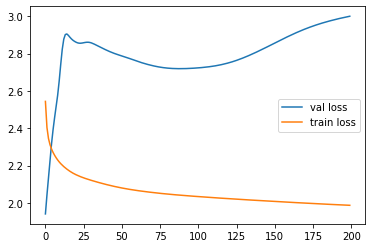

In [87]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()


# loss_valid=list(loss_list_val[i] for i in range(1,len(loss_list_val),2))
ax.plot(epoch,loss_list_val,label="val loss")
ax.plot(epoch,loss_list_train,label="train loss")
ax.legend() 
plt.savefig("twolayer_simple_loss.png")

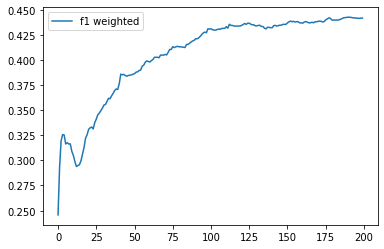

In [88]:
fig,ax2=plt.subplots()
ax2.plot(epoch,f1_list,label="f1 weighted")
# ax2.plot(epoch,loss_list_train,label="train loss")
ax2.legend()
plt.savefig("twolayer_simple_f1.png")